Загрузка данных

In [ ]:
import zipfile
from google.colab import drive


drive.mount("/content/drive")
zip_ref = zipfile.ZipFile('drive/MyDrive/hse-itmo-acoustic-event-detection-2023.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
drive.flush_and_unmount()

Импорт модулей

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import random
import scipy
import pickle

Чтение csv и перевод текстовых меток в целочисленные

In [ ]:
train_folder = './audio_train/train/'
test_folder = './audio_test/test/'

In [ ]:
label_to_num = {}
num_to_label = {}

df = pd.read_csv("train.csv")

for i, value in enumerate(df["label"].unique()):
  label_to_num[value] = i
  num_to_label[i] = value

df["label_num"] = df["label"].apply(lambda x: label_to_num[x])

files, labels = df['fname'], df['label_num']

Создание детектора акустического события

Все файлы разной длины - от 1 секунды до почти 30 - их необходимо предобработать. Здесь используем идею детекции акустических событий - по энергии mfcc спектра находим максимум энергии и "вырезаем" из каждого wav аудио длиной 2 секунды, по возможности центрируя этот максимум (то есть само событие). Если wav меньше 2 секунд, то добавляем тишину до необходимой длины.

In [ ]:
def detect_event(wav, sr, duration):
    input_length = duration * sr
    wav_length = len(wav)
    if wav_length < input_length:
        diff = input_length - wav_length
        wav = np.pad(wav, (0, diff), 'constant', constant_values=0)
    else:
        mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
        nums_in_frame = wav_length // mfcc.shape[1] + 1

        energy = np.sum(mfcc[1:]**2, axis=0)
        energy = np.repeat(energy, nums_in_frame)[:wav_length]
        idx_max_frame = np.argmax(energy) + nums_in_frame // 2

        left = idx_max_frame - input_length // 2
        rigth = idx_max_frame + input_length // 2

        if rigth > wav_length:
            wav = wav[wav_length-input_length:]
        elif left < 0:
            wav = wav[:input_length]
        else:
            wav = wav[left:rigth]

    return wav

Функция создания мелспектрограммы

In [ ]:
def get_features(wav, sr):
    melspec = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=2048,
                                             n_mels=64)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    _max = np.max(melspec)
    _min = np.min(melspec)
    melspec = (melspec - _min) / (_max - _min + 1e-9)
    melspec = melspec[..., np.newaxis]
    return melspec

Предобработка и обработка данных

In [ ]:
X = np.empty(shape=(df.shape[0], 64, 87, 1))
Y_nums = np.array(df['label_num'])
sr = 22050
duration = 2

feats = []

for i, name in enumerate(files):
    wav, sr = librosa.load(train_folder + name)
    wav, _ = librosa.effects.trim(wav)
    wav = detect_event(wav, sr, duration)
    melspec = get_features(wav, sr)
    X[i,] = melspec
    feats.append({'fname': name,
                  'melspec': melspec})

pickle.dump(feats, open('./features.pickle', 'wb'))

In [ ]:
from google.colab import drive

drive.mount("/content/drive")
!mv ./features.pickle ./drive/MyDrive/
drive.flush_and_unmount()

Визуализация данных

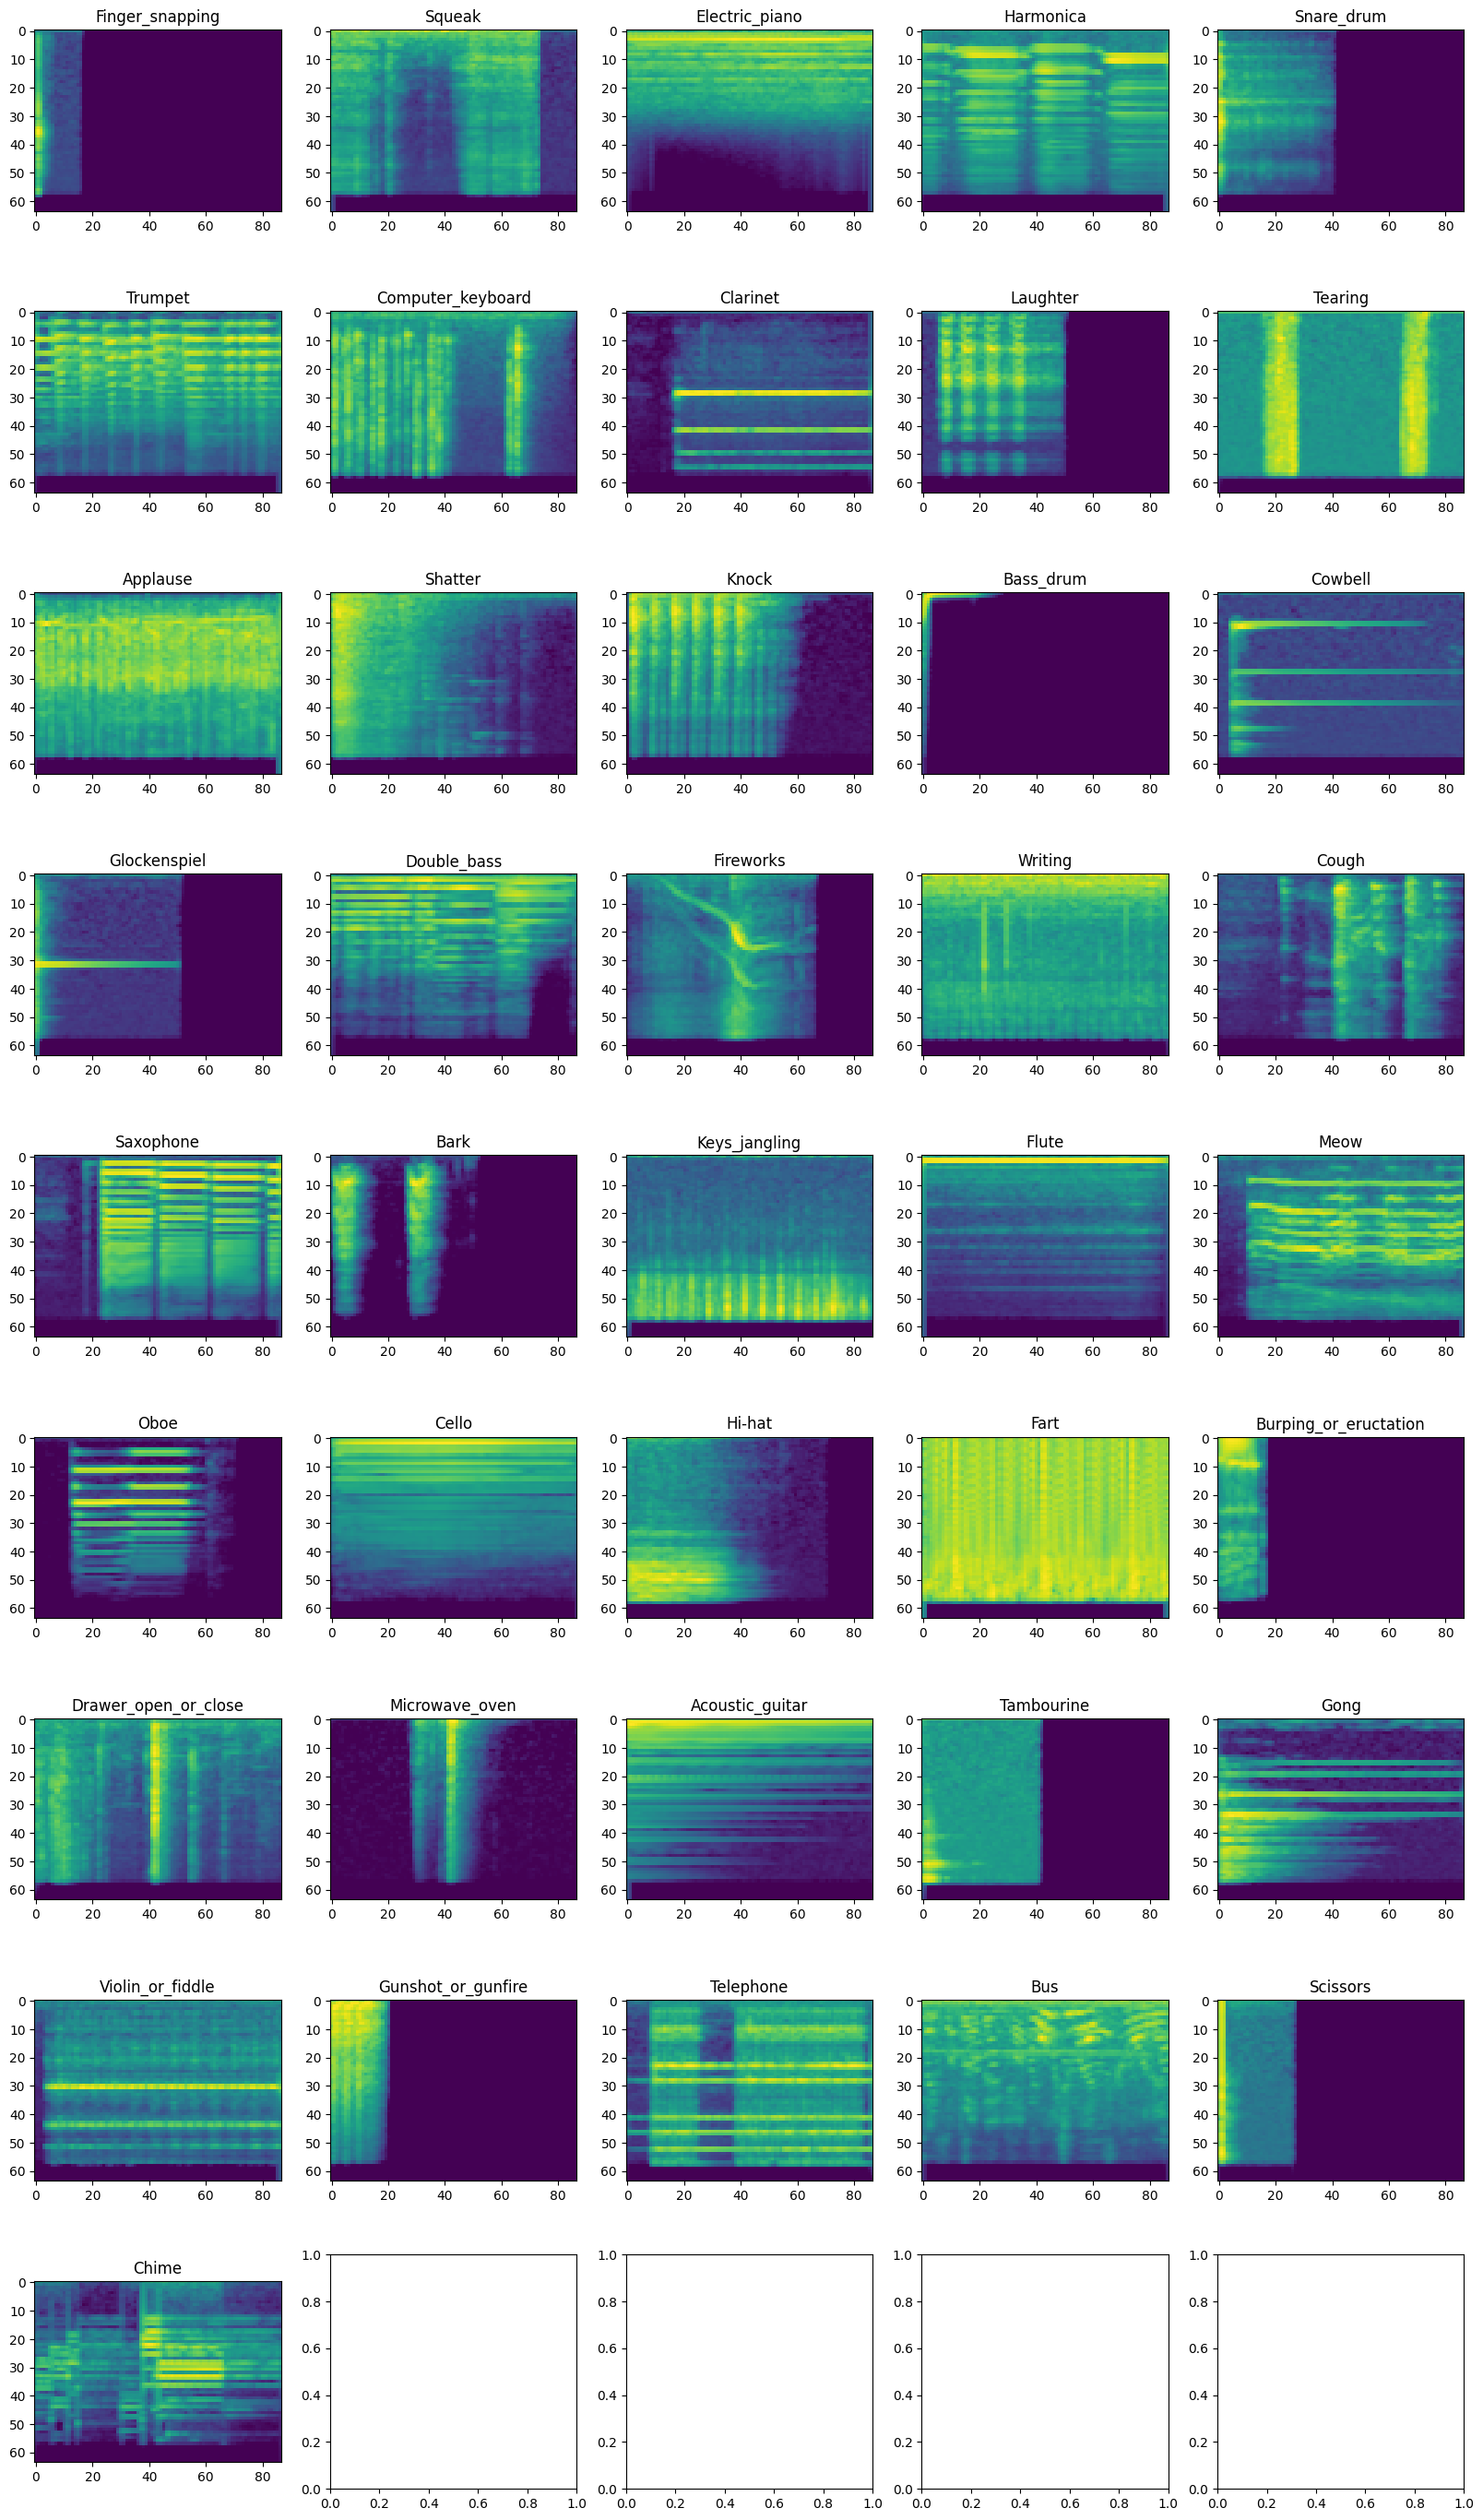

In [ ]:
def plot_melspecs(melspec, classes):
    fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(20, 35))
    row = 0
    col = 0
    for i in range(41):
        axes[row, col].set_title(classes[i])
        axes[row, col].imshow(list(melspec.values())[i])
        col += 1
        if col == 5:
          col = 0
          row += 1
    plt.show()

melspecs = {}
classes = []

for c in df['label'].unique():
    name = df[df['label']==c]['fname'].iloc[0]
    wav, sr = librosa.load(train_folder + name)
    wav, _ = librosa.effects.trim(wav)
    wav = detect_event(wav, sr, 2)
    melspec = get_features(wav, sr)
    melspecs[c] = melspec
    classes.append(c)

plot_melspecs(melspecs, classes)

Загрузка обработанных данных

In [ ]:
from google.colab import drive


drive.mount("/content/drive")
!cp ./drive/MyDrive/features.pickle ./
drive.flush_and_unmount()

In [ ]:
pickle_train_data = pickle.load(open('./features.pickle', 'rb'))

In [ ]:
X = np.empty(shape=(df.shape[0], 64, 87, 1))

for i in range(len(pickle_train_data)):
    X[i,] = pickle_train_data[i]['melspec']

Создание архитектуры нейросети

In [ ]:
from keras.layers import (Conv2D, BatchNormalization, Flatten,
                          MaxPool2D, Activation, Input, Dense, Dropout,)
from keras.models import Model
from keras.optimizers import Adam


input_model = Input(shape=(64, 87, 1))

x = Conv2D(64, (5, 5), padding="same")(input_model)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (5, 5), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(512, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(5120, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

output_model = Dense(41, activation='softmax')(x)

model = Model(inputs=input_model, outputs=output_model)

adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 87, 1)]       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 87, 64)        1664      
                                                                 
 batch_normalization_41 (Ba  (None, 64, 87, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_29 (Activation)  (None, 64, 87, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 87, 64)        102464    
                                                                 
 batch_normalization_42 (Ba  (None, 64, 87, 64)        256       
 tchNormalization)                                         

Обучение сети

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

skf = StratifiedKFold(n_splits=30)

fold_n = 1
for train, val in skf.split(X, Y_nums):
  X_train = X[train]
  Y_train = to_categorical(Y_nums[train], num_classes=41)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_n} ...')

  history = model.fit(X_train, Y_train,
              batch_size=10,
              epochs=60,
              steps_per_epoch=10,
              verbose=1)

  X_val = X[val]
  Y_val = to_categorical(Y_nums[val], num_classes=41)

  scores = model.evaluate(X_val, Y_val, verbose=0)
  print(f'Score for fold {fold_n}: {model.metrics_names[0]} : {round(scores[0], 3)}; {model.metrics_names[1]} : {round(scores[1], 3)}')

  fold_n = fold_n + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/60
10/10 [==============================] - 8s 49ms/step - loss: 4.3550 - accuracy: 0.0400
Epoch 2/60
10/10 [==============================] - 0s 50ms/step - loss: 4.2826 - accuracy: 0.0700
Epoch 3/60
10/10 [==============================] - 0s 49ms/step - loss: 3.6275 - accuracy: 0.1000
Epoch 4/60
10/10 [==============================] - 0s 50ms/step - loss: 3.9391 - accuracy: 0.0900
Epoch 5/60
10/10 [==============================] - 0s 48ms/step - loss: 3.7309 - accuracy: 0.1300
Epoch 6/60
10/10 [==============================] - 0s 49ms/step - loss: 3.7884 - accuracy: 0.0900
Epoch 7/60
10/10 [==============================] - 0s 46ms/step - loss: 3.4224 - accuracy: 0.0900
Epoch 8/60
10/10 [==============================] - 0s 46ms/step - loss: 3.5552 - accuracy: 0.1500
Epoch 9/60
10/10 [==============================] - 0s 46ms/step - loss: 3.4886 - accuracy: 0.1400
Epoch 10/60


Тестирование

In [ ]:
df_test = pd.read_csv('sample_submission.csv')
files_test = df_test['fname']

In [ ]:
X_test = np.empty(shape=(df.shape[0], 64, 87, 1), dtype=np.float32)
sr = 22050
duration = 2

for i, name in enumerate(files_test):
    wav, sr = librosa.load(test_folder + name)
    wav, _ = librosa.effects.trim(wav)
    wav = detect_event(wav, sr, duration)
    melspec, mfcc = get_features(wav, sr)
    X_test[i,] = melspec

In [ ]:
predictions = model.predict(X_test)

178/178 [==============================] - 5s 24ms/step


In [ ]:
labels = []

for i, val in enumerate(predictions):
    num = np.argmax(val)

    label = num_to_label[num]

    labels.append(label)

In [ ]:
df_test['label'] = pd.Series(labels)

In [ ]:
df_test['label']

0                 Knock
1       Acoustic_guitar
2                 Knock
3                 Knock
4              Laughter
             ...       
3785          Bass_drum
3786          Bass_drum
3787               Fart
3788        Double_bass
3789               Oboe
Name: label, Length: 3790, dtype: object

In [ ]:
df_test.to_csv('sample_submission.csv', index=False)